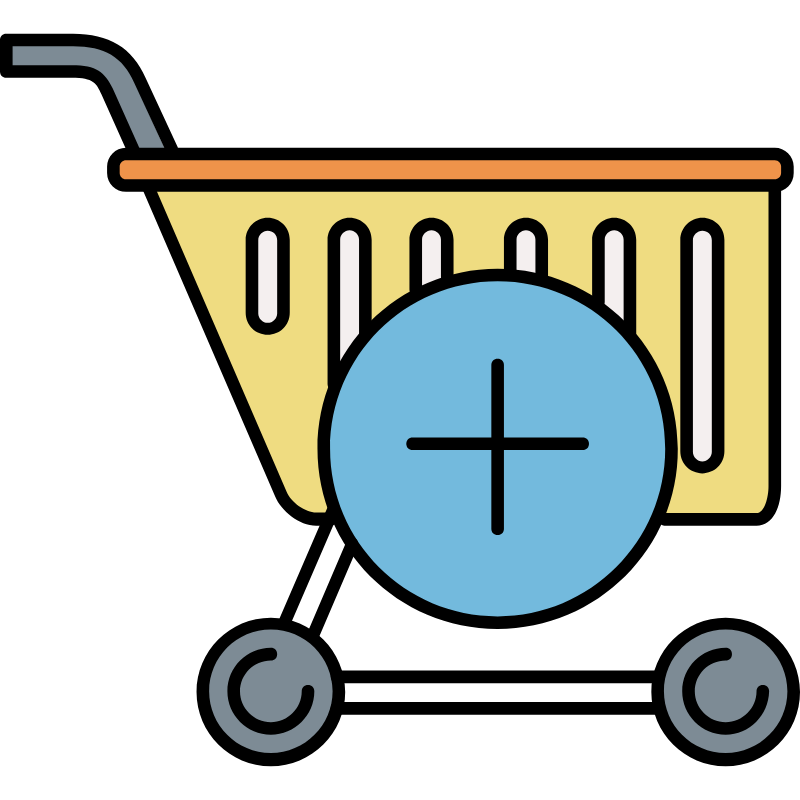

## Online Retail Store Data Analysis

### Introduction

This notebook demonstrates data cleaning and exploratory analysis on an online retail store data using python language. The approach is typical of tasks one can execute on real business data using Data Science skills. The original dataset for this analysis is from Kraggle. Specific tasks to be performed are:

- data cleaning, 
- examining and analyzing the data to see what insights I can extract from it.

Individual datasheets gathered from the retail store are as follows:

- Customer Information
- Order Item Information
- Payment Information
- Reviews Data
- Products
- Seller information
- Translations for category names
- Order Information, including shipping


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

### Loading Data

**Note:** The individual data sheets are shown as .csv files in the current repository.

In [4]:
#Customers
cust = pd.read_csv('customers.csv')

#Order Items
odr_item = pd.read_csv('order_items.csv')

#Payment Information
pay = pd.read_csv('payment_info.csv')

#Reviews
review = pd.read_csv('reviews.csv')

#Products
prod = pd.read_csv('products.csv')

#Seller information
seller = pd.read_csv('seller_info.csv')

#Translations
trans = pd.read_csv('translations.csv')

#Orders Information, including shipping
orders = pd.read_csv('orders.csv')

In [5]:
# check orders information
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       2500 non-null   object
 1   customer_id                    2500 non-null   object
 2   order_status                   2500 non-null   object
 3   order_purchase_timestamp       2500 non-null   object
 4   order_approved_at              2498 non-null   object
 5   order_delivered_carrier_date   2468 non-null   object
 6   order_delivered_customer_date  2433 non-null   object
 7   order_estimated_delivery_date  2500 non-null   object
dtypes: object(8)
memory usage: 156.4+ KB


In [6]:
#Making all of the date datetime format
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

#The dataset only contains partial data after August, so for the sake of the project, let's remove it.
orders = orders[orders['order_purchase_timestamp'] < '8/22/2018 11:59']

### Data Cleaning

The online retail data will be used for data analysis, so it must be cleaned and consolidated. I will make a couple general, clean tables, such as sales, and customers, and then tables specific to the visuals and analysis.

#### General Sales 

I'll consolidate some of the above tables into one general 'sales' table, where each row is one order, and contains general information such as the customer, and costs, while removing any detail such as specific items, or payment types.

In [7]:
# combining orders and customers data
sales = pd.merge(orders, cust, how = 'left', on = 'customer_id')

#Dropping extra date columns
sales = sales.drop(columns = ['order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date'])

#Add items info to get price and freight value data
sales = pd.merge(sales, odr_item, how = 'left', on = 'order_id')

#drop unnecessary rows
sales = sales.drop(columns = ['seller_id', 'shipping_limit_date', 'order_item_id', 'product_id'])

#grouping by the order id and adding up price and freight value, to leave one row per order
sales = sales.groupby(by = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'], as_index = False).sum()

#add 'total_price' column for easier comparison
sales['total_price'] = sales['price'] + sales['freight_value']

#adding in payment infor to get payment made so far
sales = pd.merge(sales, pay, on = 'order_id')

#dropping excess data
sales = sales.drop(columns = ['payment_sequential', 'payment_type', 'payment_installments'])

#adding up all payments, again leaving one row per order
sales = sales.groupby(by = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'price', 'freight_value','total_price'], as_index = False).sum()

#Adding a 'balanace_remaining' column
sales['balance_remaining'] = sales['total_price'] - sales['payment_value']

#Adding in review data
sales = pd.merge(sales, review, on = 'order_id', how = 'left')

#I only want the review_score, as all other data can be obtained if needed
sales = sales.drop(columns = ['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'review_id'])

#renaming the columns
sales.rename(columns = {'order_purchase_timestamp':'order_date', 'customer_unique_id':'customer_un_id', 'customer_zip_code_prefix':'zip_prefix','customer_city':'city', 'customer_state':'state'}, inplace = True)

sales

,order_id,customer_id,order_status,order_date,customer_un_id,zip_prefix,city,state,price,freight_value,total_price,payment_value,balance_remaining,review_score
0,4a5cc9b4e332e03d76bf553a7f2fa5d3,a4a00c41b5e3ed88bf0e0bb96576c2b2,delivered,2017-12-15 23:33:00+00:00,94e89532396b3c02f648b2bc7f93f528,26115.0,belford roxo,RJ,0.0,0.0,0.0,176.78,-176.78,NaN
1,5eca2113141f2c0e048b11bdcb7a0371,aa1fd99d3fa9ef872384623522665eb2,delivered,2018-01-07 15:20:00+00:00,369356185e190dbcc4ea472ef050dbbc,2611.0,sao paulo,SP,0.0,0.0,0.0,41.17,-41.17,NaN
2,d288e92a6be123f2e77f34fafd902464,2be831e199cd5308b6e3ab6f36718526,delivered,2017-11-25 00:22:00+00:00,f152faf30f85d9b5784cc9a72611a810,11310.0,sao vicente,SP,0.0,0.0,0.0,141.35,-141.35,NaN


In [9]:
# check shape
sales.shape

(3, 14)

#### Customer Lifetime Value (CLV) table

This table will be used for CLV analysis, and it quite simple, only requiring 4 columns, all of which can be taken from the 'sales' table created above

In [10]:
sales_clv = sales[['customer_id', 'customer_un_id', 'order_date', 'price']]
sales_clv

,customer_id,customer_un_id,order_date,price
0,a4a00c41b5e3ed88bf0e0bb96576c2b2,94e89532396b3c02f648b2bc7f93f528,2017-12-15 23:33:00+00:00,0.0
1,aa1fd99d3fa9ef872384623522665eb2,369356185e190dbcc4ea472ef050dbbc,2018-01-07 15:20:00+00:00,0.0
2,2be831e199cd5308b6e3ab6f36718526,f152faf30f85d9b5784cc9a72611a810,2017-11-25 00:22:00+00:00,0.0
